In [1]:
import pandas as pd

df = pd.read_csv('dementia_dataset.csv')
display(df)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


In [2]:
print(df.isnull().sum())

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64


In [ ]:
# Primero, convierte la columna 'M/F' en tipo str si no lo es
df['M/F'] = df['M/F'].astype(str)

# Luego, utiliza get_dummies() para obtener las variables one-hot
one_hot = pd.get_dummies(df['M/F'], prefix='M/F')

# Ahora puedes concatenar las variables one-hot con tu DataFrame original
df = pd.concat([df, one_hot], axis=1)

# Por último, puedes eliminar la columna original 'M/F' si ya no la necesitas
df.drop('M/F', axis=1, inplace=True)

## Limpiamos el dataset de nulos y eliminamos columnas que no usaremos en modelo
Los nulos al ser muy pocos los eliminamos porque ademas son de pruebas medicas asi que mejor no tener en cuenta esas filas que poner esos valores a 0 que podria alterar la precision de los modelos,
Las columnas que no nos dan informacion sobre la persona como el numero de visitas o los identificadores los eliminamos ya que el modelo no aprendera nada de ellas.


Pasamos la columna del sexo a tipo numerico con un mapeo.

In [3]:
df = df.dropna(subset=['SES'])
df = df.dropna(subset=['MMSE'])

df.drop(columns=['Subject ID', 'MRI ID', 'Visit'], inplace=True)

#        0=masculino      1=femenino
mapeo = {'M':0, 'F':1}
df['M/F'] = df['M/F'].map(mapeo)
#        0=izquierda      1=derecha
mapeo = {'L':0, 'R':1}
df['Hand'] = df['Hand'].map(mapeo)

display(df)

,Group,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,0,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,457,0,1,88,14,2.0,30.0,0.0,2004,0.681,0.876
5,Nondemented,0,1,1,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,Nondemented,538,1,1,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,Nondemented,0,0,1,80,12,4.0,28.0,0.0,1689,0.712,1.039
...,...,...,...,...,...,...,...,...,...,...,...,...
368,Demented,842,0,1,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,Demented,2297,0,1,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,Nondemented,0,1,1,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,Nondemented,763,1,1,63,13,2.0,30.0,0.0,1327,0.796,1.323


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

nombres_clases = ['Nondemented', 'Demented', 'Converted']

y = df['Group']
features = df.drop('Group', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=0)
# Importante escalar los datos para aumentar la precision
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = MLPClassifier(max_iter=300, hidden_layer_sizes=(100, 50), random_state=0)  
model.fit(X_train, y_train)

predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print('Perceptron: ', acc)

Perceptron:  0.9154929577464789


C:\Users\andre\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, random_state=0)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print('Random Forest', acc)

Random forest 0.9154929577464789


Decision Tree 0.8732394366197183


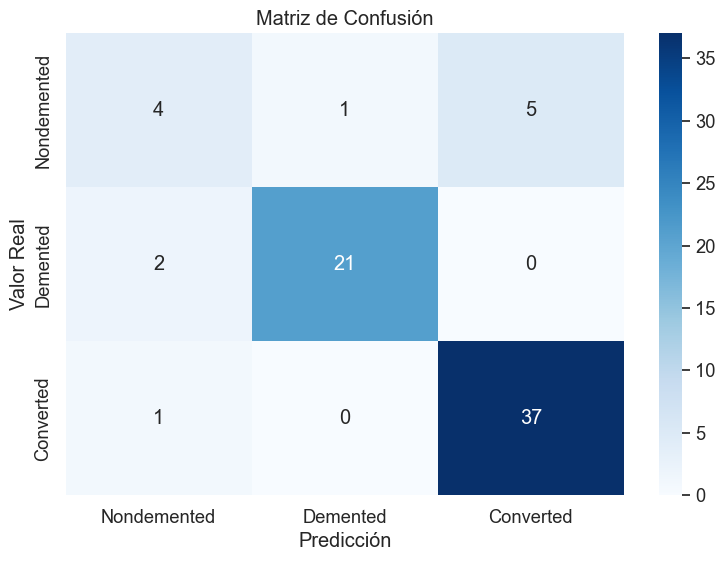

In [36]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth = 6)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print('Decision Tree', acc)


cm = confusion_matrix(y_test, predictions)
# Crear un DataFrame de la matriz de confusión para facilitar la visualización con Seaborn
cm_df = pd.DataFrame(cm, index=nombres_clases, columns=nombres_clases)
# Crear una figura
plt.figure(figsize=(9,6))
sns.set(font_scale=1.2)
# Crear un mapa de calor
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')

plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()